# **SHARPlib -- Lifting Parcels**
This is a tutorial notebook on how to conduct parcel lifting operations using SHARPlib. 

SHARPlib has a bit of a different take on parcel lifting relative to existing libraries, allowing for configurable moist adiabats and pseudoadiabats as part of the API. This also means that the API is a little more verbose, since rather than providing a one-size-fits-all function to do this, it instead provides composable functions to achieve a desired end result. If that sounds confusing, don't worry too much about it! You'll soon see how you can use the different building blocks within SHARPlib to do some rather interesting computations.

Since the SHARPlib API for parcel lifting is much more verbose than other available implementations, a quick refresher on what CAPE and CINH are could be useful. In order to facilitate customization and flexibility, the API was designed around the mathematical representation first. 

<span style="font-size:150%">$$
CAPE = \int_{\mathrm{LFC}}^{\mathrm{EL}} \frac{T_v - T_{\mathrm{env}}}{T_{\mathrm{env}}} \, dz
$$
$$
CINH = \int_{\mathrm{LPL}}^{\mathrm{LFC}} \frac{T_v - T_{\mathrm{env}}}{T_{\mathrm{env}}} \, dz
$$
</span>

**LPL** is the height of the **Lifted Parcel Level** (originating level), **LFC** is the height of the **Level of Free Convevtion**, **EL** is the height of the **Equilibrium Level**, $T_v$ is the **parcel virtual temperature**, $T_{env}$ is the **environment virtual temperature**, and $dz$ is the **delta in the height coordinate**. So, looking at these equations, we can see that in order to get CAPE, we need to integrate buoyancy... and to get buoyancy, we need the parcel virtual temperature... and to get the parcel virtual temperature, we need to define parcels to lift, and how we want them lifted. This is how the tutorial will be structured. 

## **Step 0: Imports and Loading Data**
Before we can get started, we need to import the modules we would like to use, and load some testing data provided with the repository. The data are stored in the Apache Parquet format, which Pandas can read as long as a compatible Parquet reader is installed (e.g. pyarrow, fastparquet).

The data we are using is from a real weather balloon launch -- **2016-05-24 1900 UTC at Dodge City, Kansas**. It is a raw, full resolution dataset with a sample every 1-second during the balloon ascent, containing several thousand vertical levels. This much data can be slow to process in pure-Python (for example, in SHARPpy) so it makes for an excellent example to show how powerful SHARPlib can be. However, because it is a real-world field data source, it isn't exactly clean. It contains some missing values and requires unit conversion, so a convenience function is provided below for data loading. 

This is a good time to tell you that SHARPlib expects you to be responsible for your own data formatting and pre-processing, though it does have internal QC checks for missing values. It expects all data to be in base metric units -- Pascals, Kelvin, meters / second, g / g, etc. -- rather than relying on any unit conversion libraries. 

In [1]:
from nwsspc.sharp.calc import constants
from nwsspc.sharp.calc import parcel
from nwsspc.sharp.calc import params
from nwsspc.sharp.calc import thermo
from nwsspc.sharp.calc import layer

import matplotlib.pyplot as plt
from metpy.plots import SkewT
import pandas as pd 
import numpy as np 

In [2]:
def load_parquet(filename):
    snd_df = pd.read_parquet(filename)
    snd_df = snd_df[snd_df["vwin"].notna()]
    snd_df = snd_df[snd_df["tmpc"].notna()]
    snd_df = snd_df[snd_df["relh"].notna()]
    snd_df = snd_df[snd_df["pres"] >= 50.0]

    pres = snd_df["pres"].to_numpy().astype('float32')*100.0
    hght = snd_df["hght"].to_numpy().astype('float32')
    tmpk = snd_df["tmpc"].to_numpy().astype('float32')+273.15
    dwpk = snd_df["dwpc"].to_numpy().astype('float32')+273.15
    wdir = snd_df["wdir"].to_numpy().astype('float32')
    wspd = snd_df["wspd"].to_numpy().astype('float32')
    uwin = snd_df["uwin"].to_numpy().astype('float32')
    vwin = snd_df["vwin"].to_numpy().astype('float32')

    # turn into height above ground level
    hght -= hght[0]

    mixr = thermo.mixratio(pres, dwpk)
    vtmp = thermo.virtual_temperature(tmpk, mixr)

    return {
        "pres": pres, "hght": hght,
        "tmpk": tmpk, "mixr": mixr,
        "vtmp": vtmp, "dwpk": dwpk,
        "wdir": wdir, "wspd": wspd,
        "uwin": uwin, "vwin": vwin
    }

snd_data = load_parquet("../../data/test_snds/ddc.parquet")
print(f"Number of vertical levels: {snd_data["pres"].shape[0]}")
print(f"Pressure Bottom:\t{snd_data["pres"][0]} Pa,\tHeight Bottom:\t{snd_data["hght"][0]} meters AGL")
print(f"Pressure Top:\t\t{snd_data["pres"][-1]} Pa,\tHeight Top:\t{snd_data["hght"][-1]} meters AGL") 

Number of vertical levels: 4213
Pressure Bottom:	92043.0 Pa,	Height Bottom:	0.0 meters AGL
Pressure Top:		5001.0 Pa,	Height Top:	20053.0 meters AGL


## **Step 1: Configuring the Moist Adiabats**
SHARPlib currently supports two different "parcel lifters" that can be used to compute moist ascent. The first is the Wobus lifter, which is an approximation derived by mathematician Henry Wobus and is computationally efficient. The Wobus lifter is also the method traditionally used by the SPC in its sounding and mesoanalysis computations. However, as discussed in [Davies-Jones 2007](https://journals.ametsoc.org/view/journals/mwre/136/7/2007mwr2224.1.xml), it can result in errors in the parcel temperature over 1K, and some of the assumptions in the derivation of the Wobus lifter don't hold up. The alternative provided by SHARPlib is to use the calculations from [Bryan and Fritsch 2004](https://journals.ametsoc.org/view/journals/mwre/132/10/1520-0493_2004_132_2421_aroiwp_2.0.co_2.xml), which are used in Bryan's Cloud Model 1 (CM1) to compute CAPE/CINH. The CM1 parcel lifting approach can be configured for adiabatic and pseudoadiabatic ascent, each with the ability to include or exclude ice phase processes. We'll go through how to configure these parcel lifting routines in the following cell. 

In [3]:
## Create the Wobus lifter -- it has no other configuration options
lifter_wobus = parcel.lifter_wobus()

## Create the CM1 lifter
lifter_cm1 = parcel.lifter_cm1()

## Configure the type of adiabat -- the default is to 
## use a liquid only pseudoadiabat, which is the same
## behavior of the Wobus lifter
lifter_cm1.ma_type = thermo.adiabat.pseudo_liq
## This is the full list of options available
adiabats = [member for member in dir(thermo.adiabat) if not member.startswith("_")]
print(f"All CM1 adiabats: {adiabats}")

## The CM1 lifter is an iterative solver, and we can control
## the convergence criteria and subsequently accuracy. The 
## default is 0.001 Kelvin
lifter_cm1.converge = 0.001

## The iterative solver has to integrate vertically in fine 
## increments that often involved interpolation. This setting
## controls the pressure increment (in Pa) used for integration. 
## HOWEVER -- if the data spacing in the vertical is a finer
## resolution than the pressure increment, it will use the 
## native data spacing instead. So, in this example, this 
## setting will have no effect. The default pressure increment
## is 500 Pa (5 mb).
lifter_cm1.pressure_incr = 500.0

All CM1 adiabats: ['adiab_ice', 'adiab_liq', 'pseudo_ice', 'pseudo_liq']


## **Step 2: Define parcel starting attributes**
Before lifting, we have to define the starting thermodynamic properties and originating level for ascent. SHARPlib provides a few functions to help define some standard parcel types, or you can set parcel starting attributes manually. These helper functions can help define surface based, mixed-layer, and most unstable parcels. 

### **Surface Based Parcel**
The method that creates a surface based parcel is fairly self explanatory. It sets the parcel starting temperature, dewpoint, and pressure to the values passed into the function -- typically, the first array elements of a given profile. An alternative to calling this method is to just set the parcel starting attributes manually! This function exists for convenience and to reduce verbosity. 

In [4]:
sb_pcl = parcel.Parcel.surface_parcel(snd_data["pres"][0], snd_data["tmpk"][0], snd_data["dwpk"][0])

## alternatively, can set manually
#sb_pcl = parcel.Parcel()
#sb_pcl.pres = snd_data["pres"][0]
#sb_pcl.tmpk = snd_data["tmpk"][0]
#sb_pcl.dwpk = snd_data["dwpk"][0]
## OR 
#sb_pcl = parcel.Parcel(snd_data["pres"][0], snd_data["tmpk"][0], snd_data["dwpk"][0], parcel.LPL.SFC)

print(f"Surface Based Parcel\t| pres: {sb_pcl.pres} Pa, tmpk: {sb_pcl.tmpk} K, dwpk: {sb_pcl.dwpk} K")

Surface Based Parcel	| pres: 92043.0 Pa, tmpk: 298.1499938964844 K, dwpk: 291.53192138671875 K


### **Mixed-Layer Parcel**
The method that creates a mixed-layer parcel takes in a height or pressure layer, and uses this defined layer to compute mean mixing ratio and potential temperature over that depth -- approximating the process of vertically mixing the atmosphere within that layer. The standard depth used at the Storm Prediction Center is a 100mb deep mixing layer from the surface, though any height or pressure layer can be given.  

In [5]:
mix_layer = layer.PressureLayer(snd_data["pres"][0], snd_data["pres"][0] - 1000.0)
mix_layer2 = layer.HeightLayer(0, 1000.0)

## mixing ratio is precomputed by the helper function, but not potential temperature
theta = thermo.theta(snd_data["pres"], snd_data["tmpk"])

ml_pcl = parcel.Parcel.mixed_layer_parcel(mix_layer, snd_data["pres"], theta, snd_data["mixr"])
ml_pcl2 = parcel.Parcel.mixed_layer_parcel(mix_layer2, snd_data["pres"], snd_data["hght"], theta, snd_data["mixr"])

print(f"Mixed-Layer Parcel (100 mb)\t| pres: {ml_pcl.pres} Pa, tmpk: {ml_pcl.tmpk} K, dwpk: {ml_pcl.dwpk} K")
print(f"Mixed-Layer Parcel (1 km)\t| pres: {ml_pcl2.pres} Pa, tmpk: {ml_pcl2.tmpk} K, dwpk: {ml_pcl2.dwpk} K")

Mixed-Layer Parcel (100 mb)	| pres: 92043.0 Pa, tmpk: 296.9096984863281 K, dwpk: 290.22198486328125 K
Mixed-Layer Parcel (1 km)	| pres: 92043.0 Pa, tmpk: 297.2606506347656 K, dwpk: 289.39630126953125 K


### **Most Unstable Parcel**
The most unstable parcel is a linear search over a given layer for the parcel with the largest CAPE. This is the closest to a "magic" function SHARPlib provides for getting CAPE/CINH out of a profile, but can be expesive for high vertical resolution data. In order to keep the scope of the search limited, a PressureLayer or HeightLayer must be provided. Traditionally, SPC searches for the most unstable parcel within the lowest 400 mb. 

In [6]:
search_layer = layer.PressureLayer(snd_data["pres"][0], snd_data["pres"][0] - 40000.0)

## Since CAPE/CINH are integrated, a parcel lifter
## must be provided 
mu_pcl_cm1 = parcel.Parcel.most_unstable_parcel(
    search_layer, 
    lifter_cm1,
    snd_data["pres"],
    snd_data["hght"],
    snd_data["tmpk"],
    snd_data["vtmp"],
    snd_data["dwpk"]
)

## most unstable parcel using the Wobus lifter
mu_pcl_wobf = parcel.Parcel.most_unstable_parcel(
    search_layer, 
    lifter_wobus,
    snd_data["pres"],
    snd_data["hght"],
    snd_data["tmpk"],
    snd_data["vtmp"],
    snd_data["dwpk"]
)
print(f"Most Unstable Parcel (CM1) | CAPE: {mu_pcl_cm1.cape} CINH: {mu_pcl_cm1.cinh} pres: {mu_pcl_cm1.pres} Pa, tmpk: {mu_pcl_cm1.tmpk} K, dwpk: {mu_pcl_cm1.dwpk} K")
print(f"Most Unstable Parcel (Wobus) | CAPE: {mu_pcl_wobf.cape} CINH: {mu_pcl_wobf.cinh} pres: {mu_pcl_wobf.pres} Pa, tmpk: {mu_pcl_cm1.tmpk} K, dwpk: {mu_pcl_cm1.dwpk} K")

Most Unstable Parcel (CM1) | CAPE: 3107.642822265625 CINH: -36.4101676940918 pres: 92043.0 Pa, tmpk: 298.1499938964844 K, dwpk: 291.53192138671875 K
Most Unstable Parcel (Wobus) | CAPE: 3353.407958984375 CINH: -34.56972122192383 pres: 92043.0 Pa, tmpk: 298.1499938964844 K, dwpk: 291.53192138671875 K


## **Step 3: Compute the parcel virtual temperature**
Before computing CAPE/CINH, we need to get the parcel virtual temperature trace. This then gets used to compute buoyancy, and is then integrated to get CAPE/CINH... but thats getting a bit ahead of ourselves. Getting the parcel virtual temperature trace is also incredibly useful for plotting on a Skew-T/Log-P diagram!

Lifting a parcel merely takes in the argument of the lifter to be used, and the pressure levels for which to calculate the virtual temperature on. 

In [7]:
sbpcl_virtemp_cm1 = sb_pcl.lift_parcel(lifter_cm1, snd_data["pres"])
sbpcl_virtemp_wobf = sb_pcl.lift_parcel(lifter_wobus, snd_data["pres"])

mlpcl_virtemp_cm1 = ml_pcl.lift_parcel(lifter_cm1, snd_data["pres"])
mlpcl_virtemp_wobf = ml_pcl.lift_parcel(lifter_wobus, snd_data["pres"])

mupcl_virtemp_cm1 = mu_pcl_cm1.lift_parcel(lifter_cm1, snd_data["pres"])
mupcl_virtemp_wobf = mu_pcl_wobf.lift_parcel(lifter_wobus, snd_data["pres"])

## **Step 4: Compute buoyancy**
It's a faily quick step, but before computing CAPE/CINH, we need buoyancy. We can compute it using the parcel virtual temperature and environment virtual temperature. 

***NOTE:*** You may wonder, why doesn't ```lift_parcel``` just return buoyancy instead? Well, in early verions of SHARPlib, it *did* return buoyancy, and had an optional argument to return virtual temperature, but it was clunky and didn't abide by the design goals of the library. It also made it more difficult to get the virtual temperature trace in Skew-T applications, which was not sustainable since this library was meant to fulfil that role. Instead of making the API filled with more and more optional function arguments, it was deemed better to aim for correct defaults.

In [8]:
sbpcl_buoy_cm1 = thermo.buoyancy(sbpcl_virtemp_cm1, snd_data["vtmp"])
sbpcl_buoy_wobf = thermo.buoyancy(sbpcl_virtemp_wobf, snd_data["vtmp"])

mlpcl_buoy_cm1 = thermo.buoyancy(mlpcl_virtemp_cm1, snd_data["vtmp"])
mlpcl_buoy_wobf = thermo.buoyancy(mlpcl_virtemp_wobf, snd_data["vtmp"])

mupcl_buoy_cm1 = thermo.buoyancy(mupcl_virtemp_cm1, snd_data["vtmp"])
mupcl_buoy_wobf = thermo.buoyancy(mupcl_virtemp_wobf, snd_data["vtmp"])

## **Step 5: Integrate CAPE/CINH**
Now we have all of the ingredients and tools needed to integrate CAPE/CINH. To do that, we need to find the Level of Free Convection and the Equilibrium Level. In SHARPlib, the ```parcel.Parcel.find_lfc_el``` function does this by searching for the LFC/EL combination in the profile that results in the maximum integrated buoyancy. We don't have to call this function ourselves, however, since it is called by ```parcel.Parcel.cape_cinh```. An example of calling ```parcel.Parcel.find_lfc_el``` will be done for completeness, but understand it is not always necessary. 

In [9]:
## example of find_lfc_el
## instead of returning a value,
## it sets pcl.lfc_pressure and
## pcl.eql_pressure 
sb_pcl.find_lfc_el(snd_data["pres"], snd_data["hght"], sbpcl_buoy_cm1)
print(f"Surface Based Parcel (CM1)\t| LFC: {sb_pcl.lfc_pressure} Pa\tEL: {sb_pcl.eql_pressure} Pa")
print("------")

sbcape_cm1, sbcinh_cm1 = sb_pcl.cape_cinh(snd_data["pres"], snd_data["hght"], sbpcl_buoy_cm1)
print(f"Surface Based Parcel (CM1)\t| CAPE: {sbcape_cm1} J/kg\tCINH: {sbcinh_cm1} J/kg")
sbcape_wobf, sbcinh_wobf = sb_pcl.cape_cinh(snd_data["pres"], snd_data["hght"], sbpcl_buoy_wobf)
## CAPE and CINH can also be accessed through the Parcel object
print(f"Surface Based Parcel (Wobus)\t| CAPE: {sb_pcl.cape} J/kg\tCINH: {sb_pcl.cinh} J/kg")

print("------")
mlcape_cm1, mlcinh_cm1 = ml_pcl.cape_cinh(snd_data["pres"], snd_data["hght"], mlpcl_buoy_cm1)
print(f"Mixed-Layer Parcel (CM1)\t| CAPE: {mlcape_cm1} J/kg\tCINH: {mlcinh_cm1} J/kg")
mlcape_wobf, mlcinh_wobf = ml_pcl.cape_cinh(snd_data["pres"], snd_data["hght"], mlpcl_buoy_wobf)
print(f"Mixed-Layer Parcel (Wobus)\t| CAPE: {ml_pcl.cape} J/kg\tCINH: {ml_pcl.cinh} J/kg")
print("------")

## Remember, our MUPCL has already had CAPE/CINH integrated
print(f"Most Unstable Parcel (CM1)\t| CAPE: {mu_pcl_cm1.cape} J/kg\tCINH: {mu_pcl_cm1.cinh} J/kg")
print(f"Most Unstable Parcel (Wobus)\t| CAPE: {mu_pcl_wobf.cape} J/kg\tCINH: {mu_pcl_wobf.cinh} J/kg")

Surface Based Parcel (CM1)	| LFC: 70983.0 Pa	EL: 18439.0 Pa
------
Surface Based Parcel (CM1)	| CAPE: 3107.642822265625 J/kg	CINH: -36.4101676940918 J/kg
Surface Based Parcel (Wobus)	| CAPE: 3353.407958984375 J/kg	CINH: -34.56972122192383 J/kg
------
Mixed-Layer Parcel (CM1)	| CAPE: 2212.473388671875 J/kg	CINH: -106.5482177734375 J/kg
Mixed-Layer Parcel (Wobus)	| CAPE: 2441.0380859375 J/kg	CINH: -102.0875015258789 J/kg
------
Most Unstable Parcel (CM1)	| CAPE: 3107.642822265625 J/kg	CINH: -36.4101676940918 J/kg
Most Unstable Parcel (Wobus)	| CAPE: 3353.407958984375 J/kg	CINH: -34.56972122192383 J/kg


## **Bonus #1: Plot the Parcel Traces**
We can use the parcel virtual temperature arrays we've computed and display them on a Skew-T/log-P diagram using MetPy. 

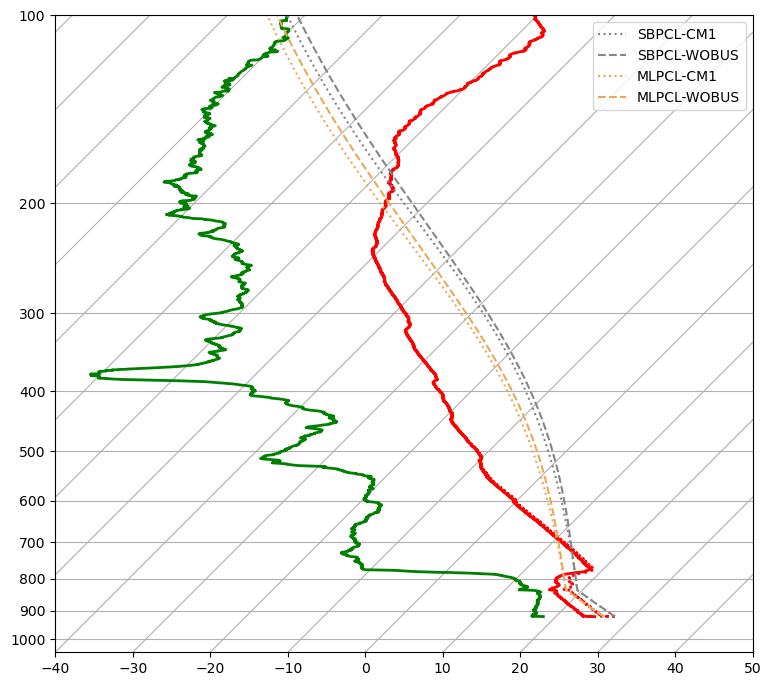

In [10]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

## Plot the temperature and dewpoint traces
## MetPy expects the pressure units in hPa (or mb) and temperature in degrees C.
skew.plot(snd_data["pres"] / 100.0, snd_data["tmpk"] - constants.ZEROCNK, 'r', linewidth=2)
skew.plot(snd_data["pres"] / 100.0, snd_data["vtmp"] - constants.ZEROCNK, 'r:', linewidth=2)
skew.plot(snd_data["pres"] / 100.0, snd_data["dwpk"] - constants.ZEROCNK, 'g', linewidth=2)

## plot our parcel traces 
## since the surface parcel is the most unstable parcel in this example, it wont be plotted
skew.plot(snd_data["pres"] / 100.0, sbpcl_virtemp_cm1 - constants.ZEROCNK, color="#858585", linestyle = ":", label="SBPCL-CM1")
skew.plot(snd_data["pres"] / 100.0, sbpcl_virtemp_wobf - constants.ZEROCNK, color="#858585", linestyle = "--", label="SBPCL-WOBUS")

skew.plot(snd_data["pres"] / 100.0, mlpcl_virtemp_cm1 - constants.ZEROCNK, color="#e8aa58", linestyle = ":", label="MLPCL-CM1")
skew.plot(snd_data["pres"] / 100.0, mlpcl_virtemp_wobf - constants.ZEROCNK, color="#e8aa58", linestyle = "--", label="MLPCL-WOBUS")

plt.legend()

# Show the plot
plt.show()

## **Bonus #2: Non-standard integration**
Sometimes, non-zero integration ranges (e.g. 0-3 km CAPE) are desired. So far, the only CAPE/CINH integration we've seen has been "automatic", whether its been the calls to ```parcel.Parcel.cape_cinh```, or the ```parcel.Parcel.most_unstable_parcel``` convenience function. Additionally, it may have felt that the process of getting CAPE/CINH has been verbose compared to the older approach in SHARPpy... but this verbosity enables a lot more flexibility in how your interact with the library, as you will see below. 

In this example, we will compute the 0-3 km CAPE, as well as the CAPE within the Hail Growth Zone. 

In [11]:
## Define the layers we want to integrate buoyancy over
cape_lyr = layer.HeightLayer(0, 3000.0)
## Compute the hail growth zone
hgz_lyr_pres = params.hail_growth_layer(snd_data["pres"], snd_data["tmpk"])
## since CAPE needs to be integrated on a height grid, 
## convert from a PressureLayer to a HeightLayer
hgz_lyr_hght = layer.pressure_layer_to_height(hgz_lyr_pres, snd_data["pres"], snd_data["hght"])

## Integate all positive buoyancy in the layer. This function integrates using the
## trapezoid method, and has optional arguments that allow for it to integrate only
## positive area, only negative area, or mixed-sign area. It can also weight the 
## integration based on the input coordinate array. Weighting is usually only done
## on pressure coordinate data, and only when needed (which it is not here).
cape_0_3km = layer.integrate_layer_trapz(cape_lyr, sbpcl_buoy_cm1, snd_data["hght"], 1, False)
cape_hgz = layer.integrate_layer_trapz(hgz_lyr_hght, sbpcl_buoy_cm1, snd_data["hght"], 1, False)

print(f"0-3 km CAPE:\t{cape_0_3km} J/kg")
print(f"HGZ CAPE:\t{cape_hgz} J/kg")


0-3 km CAPE:	101.521484375 J/kg
HGZ CAPE:	1114.3603515625 J/kg


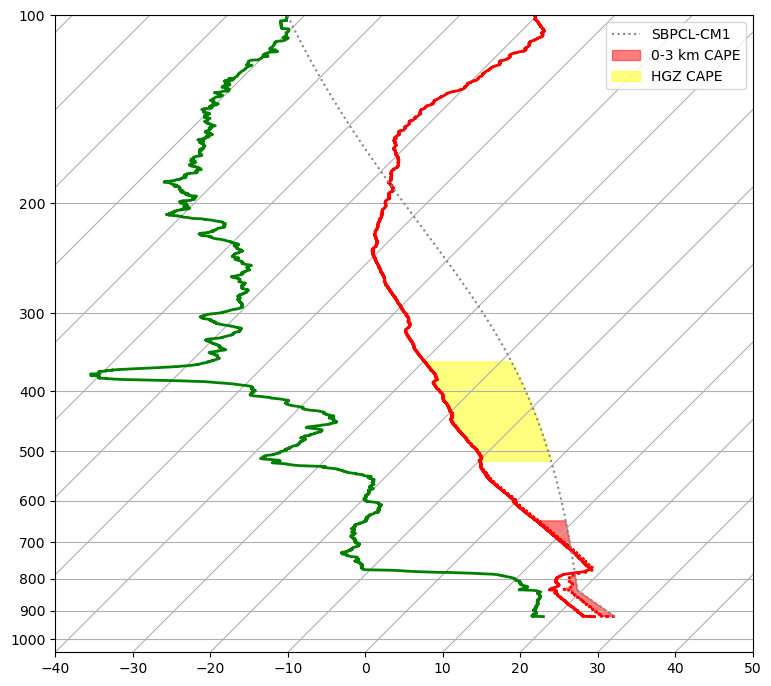

In [12]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

## get the array indices that correspond
## to our layers -- used to index our arrays
idx_03km = layer.get_layer_index(cape_lyr, snd_data["hght"])
idx_hgz = layer.get_layer_index(hgz_lyr_pres, snd_data["pres"])

## Plot the temperature and dewpoint traces
## MetPy expects the pressure units in hPa (or mb) and temperature in degrees C.
skew.plot(snd_data["pres"] / 100.0, snd_data["tmpk"] - constants.ZEROCNK, 'r', linewidth=2)
skew.plot(snd_data["pres"] / 100.0, snd_data["vtmp"] - constants.ZEROCNK, 'r:', linewidth=2)
skew.plot(snd_data["pres"] / 100.0, snd_data["dwpk"] - constants.ZEROCNK, 'g', linewidth=2)

## plot our parcel trace
skew.plot(snd_data["pres"] / 100.0, sbpcl_virtemp_cm1 - constants.ZEROCNK, color="#858585", linestyle = ":", label="SBPCL-CM1")

## Fill to show our regions
skew.shade_area(
    snd_data["pres"][idx_03km.kbot:idx_03km.ktop] / 100.0,
    sbpcl_virtemp_cm1[idx_03km.kbot:idx_03km.ktop] - constants.ZEROCNK,
    snd_data["vtmp"][idx_03km.kbot:idx_03km.ktop] - constants.ZEROCNK,
    which='positive',
    color="red", 
    alpha=0.5,
    label="0-3 km CAPE"
)

skew.shade_area(
    snd_data["pres"][idx_hgz.kbot:idx_hgz.ktop] / 100.0,
    sbpcl_virtemp_cm1[idx_hgz.kbot:idx_hgz.ktop] - constants.ZEROCNK,
    snd_data["vtmp"][idx_hgz.kbot:idx_hgz.ktop] - constants.ZEROCNK,
    which='positive',
    color="yellow", 
    alpha=0.5,
    label="HGZ CAPE"
)

plt.legend()

# Show the plot
plt.show()